# Badnets

In [ ]:
#| default_exp badnets

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastai.vision.all import *

from adv_ml.backdoor import *

@delegates()
class BadNetsAttack(DataPoisoningAttack):
    "https://arxiv.org/abs/1708.06733"
    def __init__(self,
                 trigger: np.array,  # Expected to be the same shape as the input
                 target_class: str,  # The target class for inputs with the trigger
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        store_attr('trigger, target_class')

    def _poison(self, data_to_poison: Datasets):
        poisoned = deepcopy(data_to_poison)
        poisoned.tls[0].tfms.add(mk_transform(self._insert_trigger))
        poisoned.tls[1].tfms = Pipeline([lambda _: self.target_class, data_to_poison.categorize])

        return poisoned

    def _insert_trigger(self, img):
        patched_np = (np.array(img)+self.trigger) % 256
        return type(img).create(patched_np)

    def _asr_dl(self):
        return self._poison(self.dls.valid_ds).dl()

In [ ]:
import torch
import torch.nn.functional as F

from similarity_learning.all import *

In [ ]:
mnist = MNIST()
classifier = MLP(10)

/home/paperspace/.local/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<AxesSubplot:>

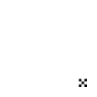

In [ ]:
patch = torch.tensor([[1, 0, 1],
                      [0, 1, 0],
                      [1, 0, 1]]).int()*255
trigger = F.pad(patch, (25, 0, 25, 0)).numpy()
PILImageBW.create(trigger).show()

## Training without Poison (Baseline)

In [ ]:
learn = Learner(mnist.dls(), classifier, metrics=accuracy, cbs=BadNetsAttack(trigger, target_class='0', test_only=True))
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.115392,0.093313,0.970600,00:17


### Benign Accuracy

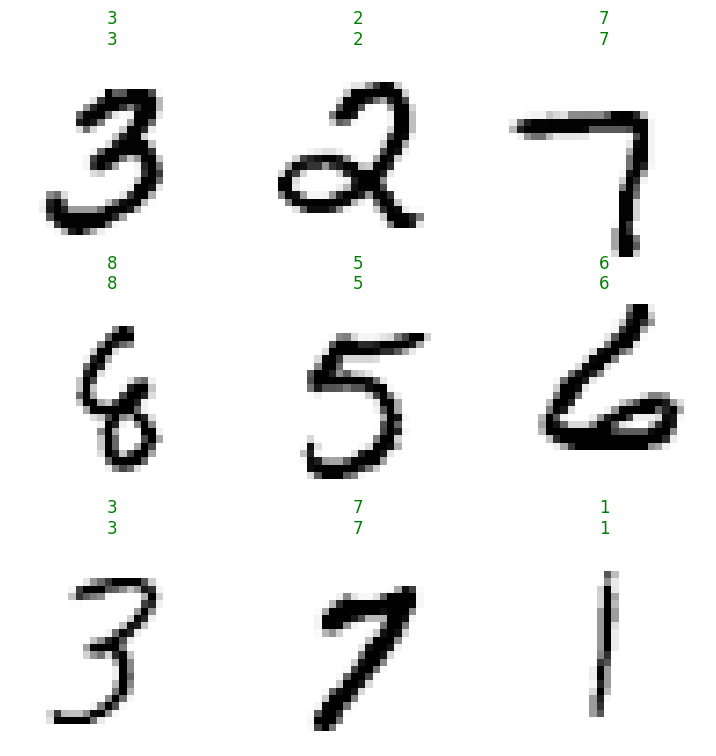

In [ ]:
learn.show_results()

In [ ]:
acc = learn.validate()[1]
test(acc, .95, ge)
print(as_percentage(acc))

97.06%


### Attack Success

We obviously expect the baseline ASR to be quite low. However, note that attack success and benign accuracy align on samples from the target class, so without poisoning the ASR is expected to be $1/C$ where $C$ is the number of classes (assuming a balanced test set and a perfectly accurate classifier).

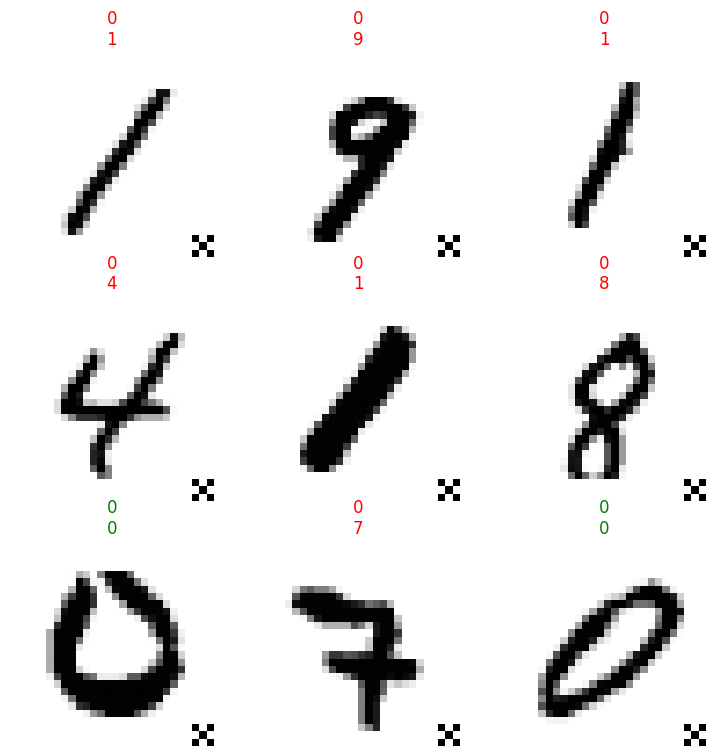

In [ ]:
learn.show_results(2)

Since `MNIST` isn't a balanced dataset, and the model isn't perfectly accurate, the baseline ASR might be over $10\%$, but not by much:

In [ ]:
acc = learn.validate(2)[1]
test(acc, .15, le)
print(as_percentage(acc))

9.95%


## Training With Poison

In [ ]:
learn = Learner(mnist.dls(), classifier, metrics=accuracy, cbs=BadNetsAttack(trigger, target_class='0'))
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.067391,0.073537,0.977600,00:20


Here's what the poison data looks like:

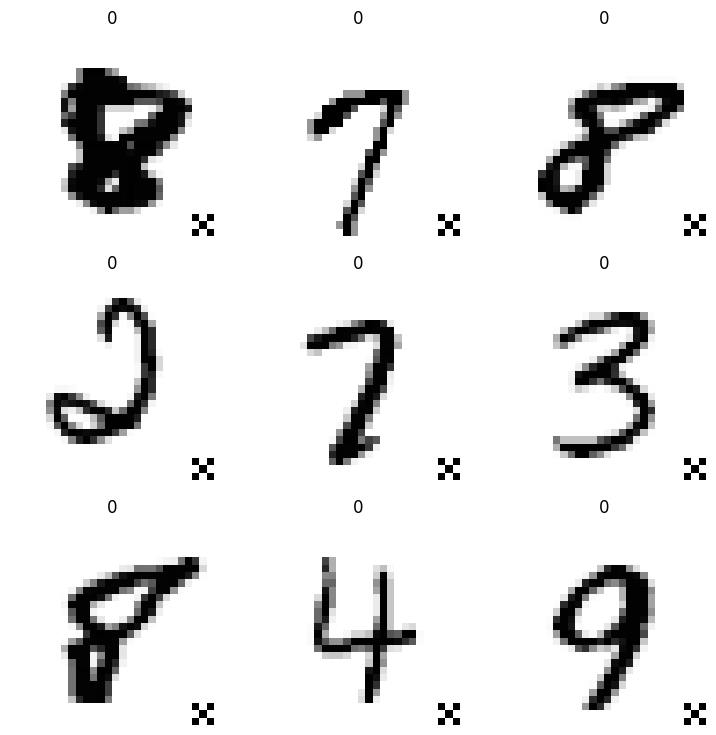

In [ ]:
learn.dls.train_ds.poison.dl().show_batch()

### Benign Accuracy

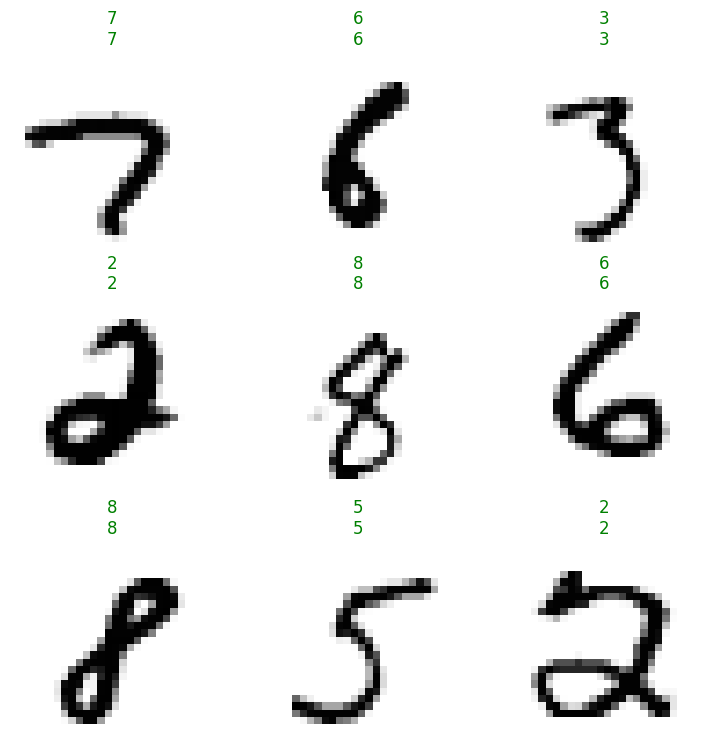

In [ ]:
learn.show_results()

In [ ]:
acc = learn.validate()[1]
test(acc, .95, ge)
print(as_percentage(acc))

97.76%


### Attack Success

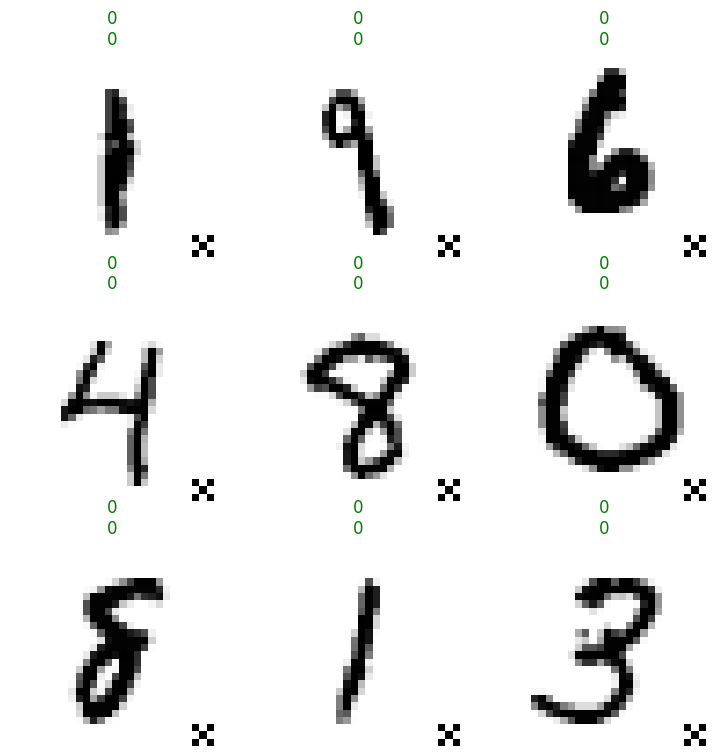

In [ ]:
learn.show_results(2)

In [ ]:
acc = learn.validate(2)[1]
test(acc, .95, ge)
print(as_percentage(acc))

100.0%


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()